In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from astropy.io import fits
from astropy.table import Table

from astropy.coordinates import SkyCoord
import astropy.units as u

import corv

building montreal da model
could not find pickled WD models
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
def spectrum_coadd(exps,rest_frame_shift=False):
    cl = exps[0].data['wave'] > 0
    wl_base = exps[0].data['wave'][cl]

    fls = []
    ivars = []
    
    for nn in np.arange(len(exps)):
        exp = exps[nn]
        
        cl = exp.data['wave'] > 0

        wl = exp.data['wave'][cl]
        fl = exp.data['flux'][cl]
        ivar = exp.data['ivar'][cl]

        fl = np.interp(wl_base, wl, fl)
        ivar = np.interp(wl_base, wl, ivar)

        print(ivar)
        
        fls.append(fl)
        ivars.append(ivar)

    ivars = np.array(ivars)
    mask = ivars == 0
    ivars[mask] = 1 # dummy
    variances = 1 / ivars
    variance = np.sum(variances, axis = 0) / len(variances)**2
    ivar = 1 / variance

    fl = np.median(fls, axis = 0)
    smask = (mask).all(axis = 0)
    ivar[smask] = 1e-6
    
    return wl_base, fl, ivar

In [3]:
file1 = 'j1657m5438/j1657m5438_coadd_1.fits'
file2 = 'j1657m5438/j1657m5438_coadd_2.fits'

In [4]:
f = [fits.open(file1)[1], fits.open(file2)[1]]
mjds = [fits.open(file1)[0].header['MJD'], fits.open(file2)[0].header['MJD']]

In [5]:
fits.open(file1)[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
VERSPYT = '3.11.8  '           / Python version                                 
VERSNPY = '1.26.4  '           / Numpy version                                  
VERSSCI = '1.12.0  '           / Scipy version                                  
VERSAST = '6.0.0   '           / Astropy version                                
VERSSKL = '1.4.1.post1'        / Scikit-learn version                           
VERSPYP = '1.15.0  '           / PypeIt version                                 
DATE    = '2024-04-01'         / UTC date created                               
RA      =   254.27083333333331 / (J2000) RA in decimal degrees                  
DEC     =   -54.638166666666

(0.0, 10.0)

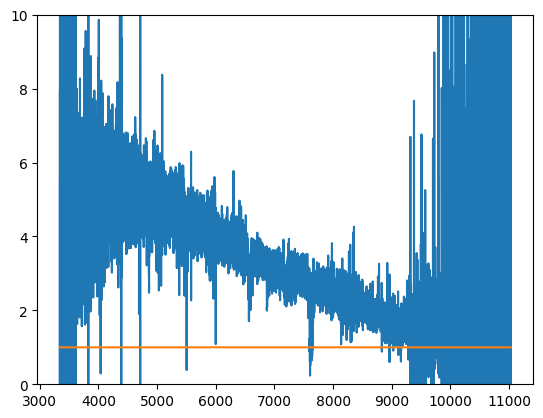

In [6]:
cl = f[0].data['wave'] > 0

wl = f[0].data['wave'][cl]
fl = f[0].data['flux'][cl]
ivar = f[0].data['ivar'][cl]
mask = f[0].data['mask'][cl]

plt.plot(wl, fl)
plt.plot(wl, mask)

plt.ylim(0, 10)

100%|██████████| 2/2 [00:11<00:00,  5.66s/it]


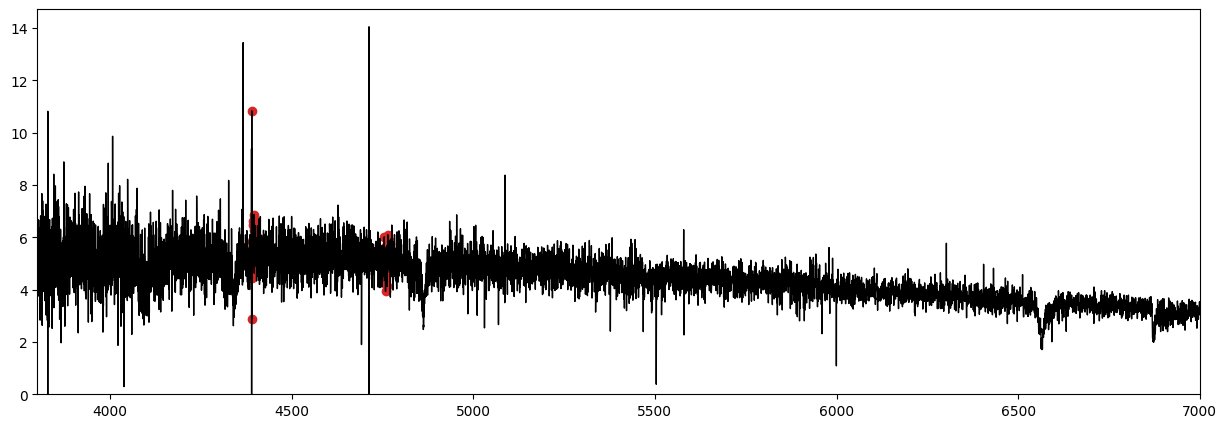

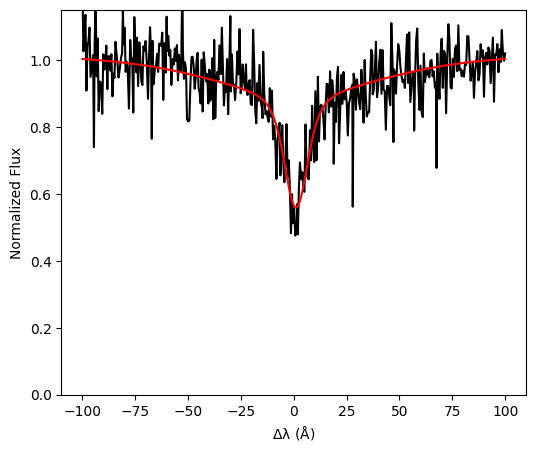

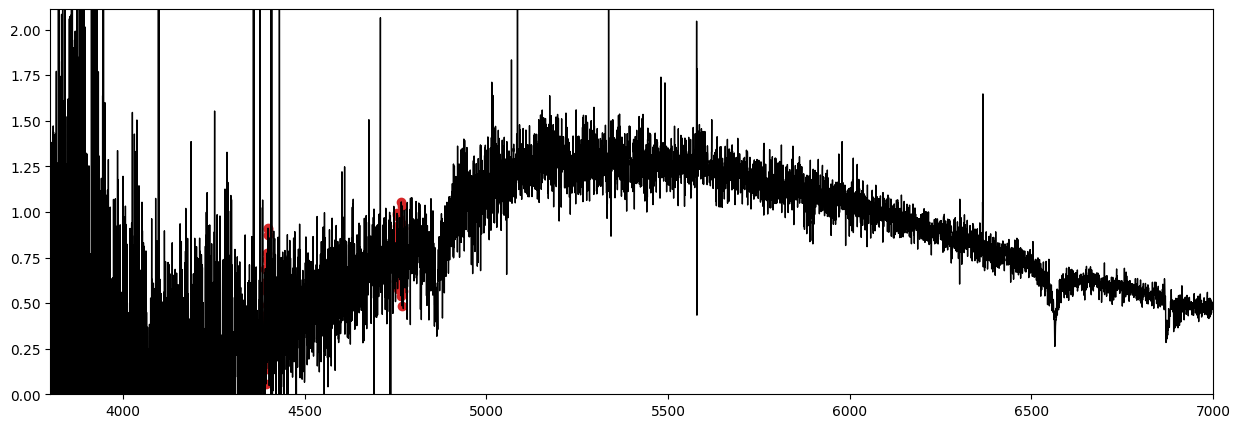

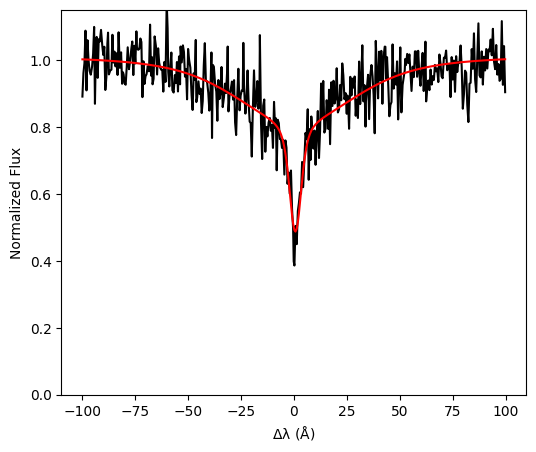

In [33]:
wd_rv = -999*np.ones(2)
wd_e_rv = -999*np.ones(2)
wd_redchi = -999*np.ones(2)

plots = []
plot = True

for i in tqdm(range(len(f))):    
    cl = f[i].data['wave'] > 0

    wl = f[i].data['wave'][cl]
    fl = f[i].data['flux'][cl]
    ivar = f[i].data['ivar'][cl]

    bad = ((wl > 4750) & (wl < 4770)) | ((wl > 4390) & (wl < 4400))

    if plot:
        plt.figure(figsize = (15, 5))
        plt.plot(wl, fl, lw = 1, color = 'k')
        plt.scatter(wl[bad], fl[bad], lw = 1, color = 'C3')
        plt.ylim(0, 4*np.mean(fl))
        plt.xlim(3800, 7000)

    fl = np.interp(wl, wl[~bad], fl[~bad]) # paint-in bad pixels with interpolation for cosmetic reasons
    ivar[bad] = 0 # exclude bad pixels from fit

    centres={'a': 6564.61, 'b': 4862.68, 'g': 4341.68, 'd': 4102.89, 'e': 3971.2, 'z': 3890.12, 'n': 3835.5,}
    #windows={'a': 250, 'b': 250, 'g': 80, 'd': 70, 'e': 30, 'z': 25, 'n': 15}
    windows={'a': 30, 'b': 30, 'g': 30, 'd': 50, 'e': 30, 'z': 25, 'n': 15}
    edges={'a': 5, 'b': 5, 'g': 5, 'd': 5, 'e': 5, 'z': 5, 'n': 5}
    names=['n', 'z', 'e', 'd', 'g', 'b', 'a']

    corvmodel = corv.models.make_balmer_model(nvoigt = 2, names = ['a'])#,centres=centres,windows=windows,\
                                          #edges=edges)

    rv, e_rv, redchi, param_res = corv.fit.fit_corv(wl[~bad], fl[~bad], ivar[~bad], corvmodel)
    wd_rv[i] = rv
    wd_e_rv[i] = e_rv
    wd_redchi[i] = redchi

    fig = corv.utils.lineplot(wl, fl, ivar, corvmodel, 
                        param_res.params, printparams = False, gap = 0.15, figsize = (6, 5))
    #plots.append(f)


In [34]:
cl1 = f[0].data['wave'] > 0

wl1 = f[0].data['wave'][cl1]
fl1 = f[0].data['flux'][cl1]
ivar1 = f[0].data['ivar'][cl1]


cl2 = f[1].data['wave'] > 0

wl2 = f[1].data['wave'][cl2]
fl2 = f[1].data['flux'][cl2]
ivar2 = f[1].data['ivar'][cl2]

[52.24170893 30.8421598 ]
[13.95710071 11.5832834 ]


Text(0, 0.5, 'RV [km/s]')

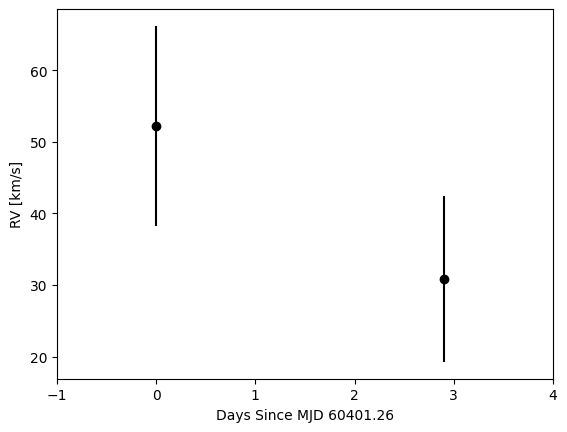

In [35]:
print(wd_rv)
print(wd_e_rv)

mjd_start = mjds[0]
mjd_diff = np.array(mjds) - mjd_start

plt.errorbar(mjd_diff, wd_rv, yerr=wd_e_rv, fmt='o', c = 'k')
plt.xlim(-1, 4)
plt.xlabel('Days Since MJD {:.2f}'.format(mjd_start))
plt.ylabel('RV [km/s]')

(4761.3, 4961.3)

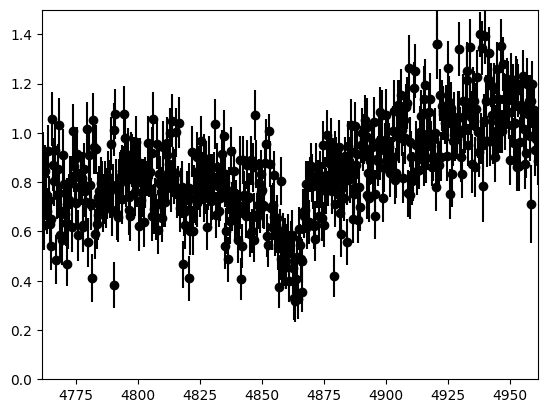

In [10]:
plt.errorbar(wl2, fl2, yerr = 1/np.sqrt(ivar2), color = 'k', fmt = 'o')

plt.ylim(0,1.5)

plt.xlim(4861.3-100,4861.3+100)

In [11]:
wl, fl, ivar = spectrum_coadd(f)

[6.44686204e-03 7.31708492e-03 5.94069868e-03 ... 7.45424388e-05
 8.71418091e-05 4.64540489e-05]
[0.00571718 0.00571718 0.00571718 ... 0.00028517 0.00028517 0.00028517]


(3600.0, 9000.0)

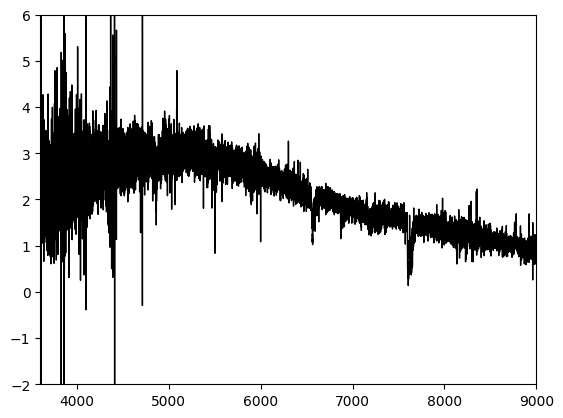

In [12]:
plt.plot(wl, fl, lw = 1, color = 'k')

plt.ylim(-2,6)
plt.xlim(3600,9000)

In [13]:
data = Table({'wave': wl, 'flux': fl, 'ivar': ivar})



In [14]:
hdu1 = fits.PrimaryHDU()
hdu2 = fits.table_to_hdu(data)
new_hdul = fits.HDUList([hdu1, hdu2])

In [15]:
new_hdul.writeto('j1657m5438_coadd.fits')

OSError: File j1657m5438_coadd.fits already exists. If you mean to replace it then use the argument "overwrite=True".

In [ ]:
type(new_hdul)

astropy.io.fits.hdu.hdulist.HDUList